# Entanglement Capabilities of Different Ansatzes

In [62]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from analysis_functions import Analysis
import sys
sys.path.append("../")
from vqc.vqc_circuits import UQC

To measure entanglement capability of the different ansatzes, we are going to use the Meyer-Wallach entanglement measure $Q$ of the states generated by it. Here, there are actually three different things we can do:
 - 1) Simply characterize the entanglement capability of the ansatz by measuring Q of the PQC with random weights.
 - 2) Measure Q of the PQC with the final weights and see how much entanglement the PQC has at the end of training.
 - 3) Measure Q every x training steps and see how entanglement evolves during training.

Measure the entanglement of a state:

$$Q(\ket{\psi}) = 2\left(1 - \frac{1}{n}\sum_{j=1}^{n}Tr(\rho_j^2)\right)$$

Measure the entanglement cabaibility of a PQC:

$$Q(\ket{\psi}) = \frac{2}{|S|}\sum_{\theta_i\in S}\left(1 - \frac{1}{n}\sum_{j=1}^{n}Tr(\rho_j^2(\theta_i))\right)$$

## 1) Entanglement Capability of the different ansatzes

In [63]:
def skolik_variational_layer(wires, params):
    [qml.RY(params[i,0], wires[i]) for i in range(len(wires))]
    [qml.RZ(params[i,1], wires[i]) for i in range(len(wires))]

def skolik_entangling_layer(wires):
    [qml.CZ(wires = [i,j]) for i,j in zip(wires, wires[1:])]
    if len(wires) != 2:
        qml.CZ(wires = [wires[0], wires[-1]])

def cnots_circular_layer(wires):
    [qml.CNOT(wires = [i,j]) for i,j in zip(wires, wires[1:])]
    if len(wires) != 2:
        qml.CNOT(wires = [wires[0], wires[-1]])

def full_entangling_layer_cnot(wires):
    [qml.CNOT(wires = [i,j]) for i in wires for j in wires if i != j]

def full_entangling_layer_cz(wires):
    [qml.CZ(wires = [i,j]) for i in wires for j in wires if i != j]

def skolik_data_encoding(wires, data, params):
    [qml.RX(data[i] * params[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

def uqc_layer( wires, data, rotational_weights, input_weights, bias_weights):
    [qml.RZ(np.dot(2 * input_weights[i], data) + bias_weights[i] , wires[i]) for i in range(len(wires))]
    [qml.RY(2 * rotational_weights[i], wires[i]) for i in range(len(wires))]

def schuld_datareup(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    input_weights = params[0]
    rotational_weights = params[1]
    for l in range(num_layers):
        skolik_variational_layer(range(4), rotational_weights[l])
        entangling_layer(range(4))
        skolik_data_encoding(range(4), data, input_weights[l])
    skolik_variational_layer(range(4), rotational_weights[num_layers-1])
    return qml.density_matrix(qubit_to_measure)

def uqc(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    rotational_weights = params[0]
    input_weights = params[1]
    bias_weights = params[2]
    for l in range(num_layers):
        uqc_layer(range(num_qubits), data, rotational_weights[l], input_weights[l], bias_weights[l])
        entangling_layer(range(num_qubits))
    return qml.density_matrix(qubit_to_measure)

In [64]:
dev_4qubits = qml.device("default.qubit", wires = 4)
dev_2qubits = qml.device("default.qubit", wires = 2)

skolik_datareup_circuit = qml.QNode(schuld_datareup, dev_4qubits)
uqc_2qubits_circuit = qml.QNode(uqc, dev_2qubits)
uqc_4qubits_circuit = qml.QNode(uqc, dev_4qubits)

In [47]:
def q(circuit,weights, num_qubits, num_layers, data, entangling_layer):
    """
    Returns the Meyer-Wallach measure of entanglement of the state produced by the circuit
    """
    entropy = 0
    for j in range(num_qubits):
        reduced_density_matrix = circuit(weights, num_qubits, num_layers, data, j, entangling_layer)
        trace = np.trace(np.matmul(reduced_density_matrix, reduced_density_matrix))
        entropy += trace
    entropy /= num_qubits
    entropy = 1 - entropy
    return 2*entropy

def entangling_capability(circuit, num_qubits, num_layers, circuit_arch, entangling_layer, sample = 1024):
    """
    Uses the Meyer-Wallach measure of entanglement to compute the entangling capability of the circuit
    """
    res = np.zeros(sample, dtype = complex)

    for i in range(sample):
        if circuit_arch == "uqc":
            params = [np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits, 4)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits))]
        else:
            params = [np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits)),
                      np.random.uniform(low = 0, high = 2*np.pi, size = (num_layers, num_qubits, 2))]
            
        data = np.random.uniform(low = -0.05, high = 0.05, size = 4)
        res[i] = q(circuit, params, num_qubits, num_layers, data, entangling_layer)
    
    return np.sum(res).real/sample

In [65]:
entangling_capability_uqc_4qubits = entangling_capability(uqc_4qubits_circuit, 4, 5, "uqc", skolik_entangling_layer, sample = 16)
entangling_capability_uqc_2qubits = entangling_capability(uqc_2qubits_circuit, 2, 5, "uqc", skolik_entangling_layer, sample = 16)

In [66]:
entangling_capability_skolik_skolik_entangling = entangling_capability(skolik_datareup_circuit, 4, 5, "schuld", skolik_entangling_layer, sample = 16)
entangling_capability_skolik_cnots_circular_layer = entangling_capability(skolik_datareup_circuit, 4, 5, "schuld", cnots_circular_layer, sample = 16)
entangling_capability_skolik_full_entangling_layer_cnot = entangling_capability(skolik_datareup_circuit, 4, 5, "schuld", full_entangling_layer_cnot, sample = 16)
entangling_capability_skolik_full_entangling_layer_cz = entangling_capability(skolik_datareup_circuit, 4, 5, "schuld", full_entangling_layer_cz, sample = 16)

In [67]:
print("Entangling capability of UQC with 4 qubits: ", entangling_capability_uqc_4qubits)
print("Entangling capability of UQC with 2 qubits: ", entangling_capability_uqc_2qubits)
print("Entangling capability of Schuld with 4 qubits and Skolik entangling layer: ", entangling_capability_skolik_skolik_entangling)
print("Entangling capability of Schuld with 4 qubits and CNOTs circular entangling layer: ", entangling_capability_skolik_cnots_circular_layer)
print("Entangling capability of Schuld with 4 qubits and full entangling layer with CNOTs: ", entangling_capability_skolik_full_entangling_layer_cnot)
print("Entangling capability of Schuld with 4 qubits and full entangling layer with CZs: ", entangling_capability_skolik_full_entangling_layer_cz)

Entangling capability of UQC with 4 qubits:  0.7230875929262977
Entangling capability of UQC with 2 qubits:  0.45237482590291955
Entangling capability of Schuld with 4 qubits and Skolik entangling layer:  0.7602389477549653
Entangling capability of Schuld with 4 qubits and CNOTs circular entangling layer:  0.8307356535677435
Entangling capability of Schuld with 4 qubits and full entangling layer with CNOTs:  0.842537961380674
Entangling capability of Schuld with 4 qubits and full entangling layer with CZs:  -1.3128387266192476e-14


## 2) Entanglement During training

In [105]:
uqc_2qubits_training_path = "../../results/entanglement_training/2_qubit_uqc_cz"
skolik_datareup_training_path = "../../results/entanglement_training/skolik_datareup"

uqc_2qubits_training = Analysis(uqc_2qubits_training_path)
skolik_datareup_training = Analysis(skolik_datareup_training_path)

In [106]:
uqc_2qubits_training_return = uqc_2qubits_training.get_rewards()
skolik_datareup_training_return = skolik_datareup_training.get_rewards()

uqc_2qubits_training_mean_return = np.mean(uqc_2qubits_training_return, axis = 0)
skolik_datareup_training_mean_return = np.mean(skolik_datareup_training_return, axis = 0)

uqc_2qubits_training_std_return = np.std(uqc_2qubits_training_return, axis = 0)
skolik_datareup_training_std_return = np.std(skolik_datareup_training_return, axis = 0)

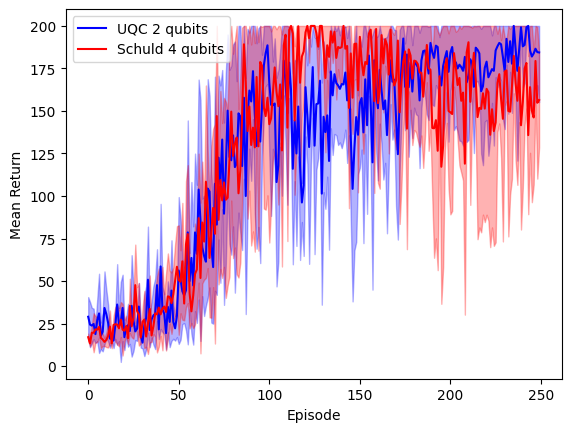

In [107]:
plt.plot(uqc_2qubits_training_mean_return,color = "blue", label = "UQC 2 qubits")
plt.plot(skolik_datareup_training_mean_return,color = "red", label = "Schuld 4 qubits")
plt.fill_between(range(len(uqc_2qubits_training_mean_return)), uqc_2qubits_training_mean_return - uqc_2qubits_training_std_return, np.clip(uqc_2qubits_training_mean_return + uqc_2qubits_training_std_return, a_min = None, a_max = 200), alpha = 0.3, color = "blue")
plt.fill_between(range(len(skolik_datareup_training_mean_return)), skolik_datareup_training_mean_return - skolik_datareup_training_std_return, np.clip(skolik_datareup_training_mean_return + skolik_datareup_training_std_return, a_min = None, a_max = 200), alpha = 0.3, color = "red")
plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend()
plt.show()

In [108]:
weights_training = uqc_2qubits_training.get_weights_training()

skolik_weights_training = skolik_datareup_training.get_weights_training()

In [109]:
for i in range(len(weights_training)):
    for j in range(len(weights_training[i])):
        weights_training[i][j] = weights_training[i][j][:-1]

for i in range(len(skolik_weights_training)):
    for j in range(len(skolik_weights_training[i])):
        skolik_weights_training[i][j] = skolik_weights_training[i][j][:-1]

In [110]:
num_layers = 5
num_qubits = 2

num_qubits_skolik = 4

for i in range(len(weights_training)):
    for j in range(len(weights_training[i])):
        weights_training[i][j][0] = weights_training[i][j][0].reshape(num_layers, num_qubits)

for i in range(len(skolik_weights_training)):
    for j in range(len(skolik_weights_training[i])):
        skolik_weights_training[i][j][0] = skolik_weights_training[i][j][0].reshape(num_layers, num_qubits_skolik)

ValueError: cannot reshape array of size 48 into shape (5,4)

In [92]:
def entangling_training(circuit, num_qubits, num_layers,params, entangling_layer, sample = 512):
    """
    Uses the weights of the PQC during training to calculate the entanglement capability of the PQC throughout the training process.
    To do that, it generates 512 random initial states and calculates the entanglement capability of the PQC with those states.
    """
    res = np.zeros((len(params),sample), dtype = complex)
    result = np.zeros(len(params), dtype = complex)

    for i in range(len(params)):
        for j in range(sample):
            data = np.random.uniform(low = -0.05, high = 0.05, size = 4)
            res[i][j] = q(circuit, params[i], num_qubits, num_layers, data, entangling_layer)
    
    for i in range(len(params)):
        result[i] = np.sum(res[i]).real/sample
    
    return result

In [99]:
def skolik_variational_layer(wires, params):
    [qml.RY(params[i,0], wires[i]) for i in range(len(wires))]
    [qml.RZ(params[i,1], wires[i]) for i in range(len(wires))]

def skolik_entangling_layer(wires):
    [qml.CZ(wires = [i,j]) for i,j in zip(wires, wires[1:])]
    if len(wires) != 2:
        qml.CZ(wires = [wires[0], wires[-1]])

def cnots_circular_layer(wires):
    [qml.CNOT(wires = [i,j]) for i,j in zip(wires, wires[1:])]
    if len(wires) != 2:
        qml.CNOT(wires = [wires[0], wires[-1]])

def full_entangling_layer_cnot(wires):
    [qml.CNOT(wires = [i,j]) for i in wires for j in wires if i != j]

def full_entangling_layer_cz(wires):
    [qml.CZ(wires = [i,j]) for i in wires for j in wires if i != j]

def skolik_data_encoding(wires, data, params):
    [qml.RX(data[i] * params[i], wires[i], id = f"x_{i}") for i in range(len(wires))]

def uqc_layer( wires, data, rotational_weights, input_weights, bias_weights):
    [qml.RZ(np.dot(2 * input_weights[i], data) + bias_weights[i] , wires[i]) for i in range(len(wires))]
    [qml.RY(2 * rotational_weights[i], wires[i]) for i in range(len(wires))]

def schuld_datareup(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    input_weights = params[0]
    rotational_weights = params[1]
    for l in range(num_layers):
        skolik_variational_layer(range(4), rotational_weights[l])
        entangling_layer(range(4))
        skolik_data_encoding(range(4), data, input_weights[l])
    skolik_variational_layer(range(4), rotational_weights[num_layers-1])
    return qml.density_matrix(qubit_to_measure)

def uqc(params, num_qubits, num_layers, data, qubit_to_measure, entangling_layer):
    rotational_weights = params[0]
    input_weights = params[1]
    bias_weights = params[2]
    for l in range(num_layers):
        uqc_layer(range(num_qubits), data, rotational_weights[l], input_weights[l], bias_weights[l])
        entangling_layer(range(num_qubits))
    return qml.density_matrix(qubit_to_measure)

dev_2qubits = qml.device("default.qubit", wires = 2)

uqc_2qubits_circuit = qml.QNode(uqc, dev_2qubits)

entangling_training_uqc_2qubits_cz_0 = entangling_training(uqc_2qubits_circuit, 2, 5, weights_training[0], skolik_entangling_layer, sample = 64)
entangling_training_uqc_2qubits_cz_1 = entangling_training(uqc_2qubits_circuit, 2, 5, weights_training[1], skolik_entangling_layer, sample = 64)
entangling_training_uqc_2qubits_cz_2 = entangling_training(uqc_2qubits_circuit, 2, 5, weights_training[2], skolik_entangling_layer, sample = 64)
entangling_training_uqc_2qubits_cz_3 = entangling_training(uqc_2qubits_circuit, 2, 5, weights_training[3], skolik_entangling_layer, sample = 64)
entangling_training_uqc_2qubits_cz_4 = entangling_training(uqc_2qubits_circuit, 2, 5, weights_training[4], skolik_entangling_layer, sample = 64)


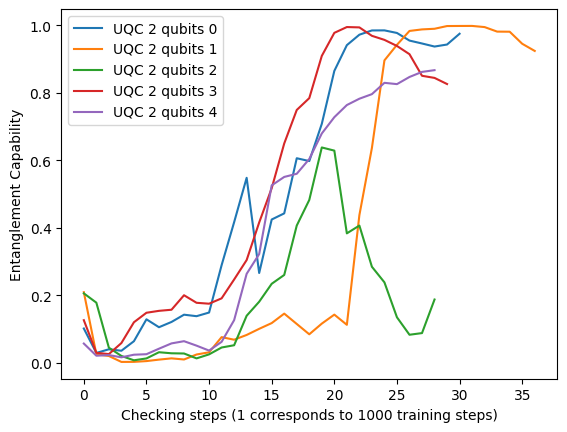

In [104]:
plt.plot(entangling_training_uqc_2qubits_cz_0, label = "UQC 2 qubits 0")
plt.plot(entangling_training_uqc_2qubits_cz_1, label = "UQC 2 qubits 1")
plt.plot(entangling_training_uqc_2qubits_cz_2, label = "UQC 2 qubits 2")
plt.plot(entangling_training_uqc_2qubits_cz_3, label = "UQC 2 qubits 3")
plt.plot(entangling_training_uqc_2qubits_cz_4, label = "UQC 2 qubits 4")
plt.xlabel("Checking steps (1 corresponds to 1000 training steps)")
plt.ylabel("Entanglement Capability")
plt.legend()
plt.show()